### Cysteine metabolism correlation analysis
Here we explore more in depth the Cellfie analysis performed in Human Secretome Manuscript (https://docs.google.com/document/d/1wf7WS_8eKEnORkM-X4U-q0IeHBB0281lRp31aE2BqzI/edit?tab=t.0#heading=h.lnxbz9) to explore the correlation between cysteine metabolism tasks and protein yield

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [10]:
# Function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_2903/4251971087.py:68: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_value, _ = stats.pearsonr(


<Figure size 1200x1000 with 0 Axes>

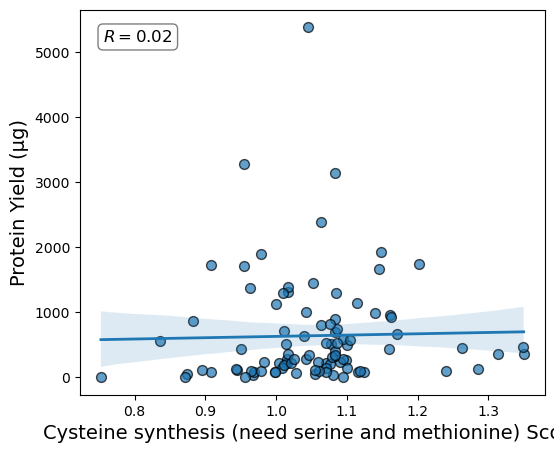

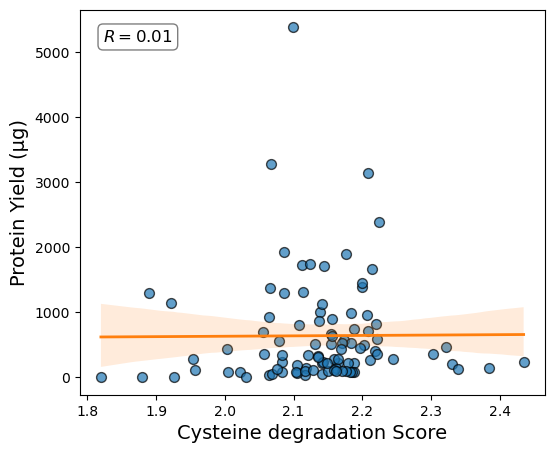

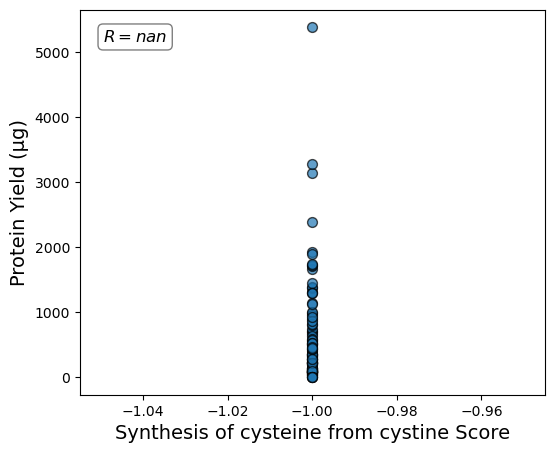

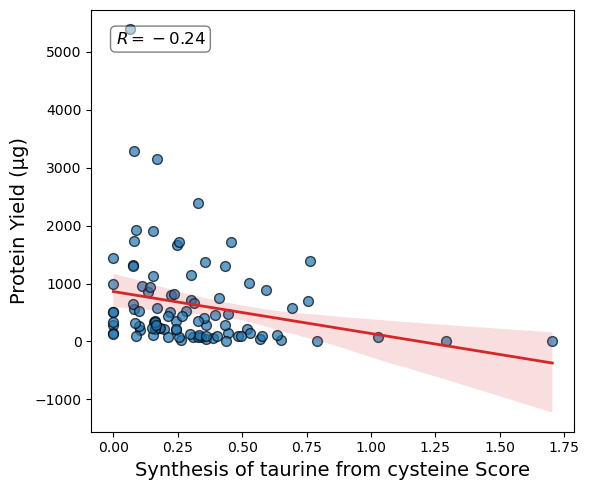

In [15]:
# Load data files
file_path = 'data/Supplementary Data 3 - Cellfie Analysis.xlsx'
csv_file_path = 'data/supplementary_data_1.csv'

# Load protein yield data
protein_yield_data = pd.read_csv(csv_file_path)
protein_yield = protein_yield_data[['sample_ID', 'Total.purified.protein_stock1.stock2_microg']]

# Load "Score" sheet
scores = pd.read_excel(file_path, sheet_name='Score', header=None)

# Define cysteine-related tasks and their corresponding rows (0-based indexing)
cysteine_tasks = {
    "Cysteine synthesis (need serine and methionine)": 80,
    "Cysteine degradation": 81,
    "Synthesis of cysteine from cystine": 82,
    "Synthesis of taurine from cysteine": 83
}

# Initialize an empty list to store structured data for all tasks
all_tasks_data = []

# Process each task
for task_name, task_row in cysteine_tasks.items():
    # Extract scores for the task
    task_scores = scores.iloc[task_row, :]

    # Convert scores into a DataFrame
    task_scores = task_scores.reset_index()
    task_scores.columns = ['sample_index', 'Score']

    # Add sample IDs (assuming columns map to sample IDs in protein yield data)
    task_scores['sample_ID'] = protein_yield['sample_ID'].values

    # Merge scores with protein yield data
    merged_data = pd.merge(protein_yield, task_scores, on='sample_ID', how='inner')

    # Convert to numeric and drop missing values
    merged_data['Total.purified.protein_stock1.stock2_microg'] = pd.to_numeric(
        merged_data['Total.purified.protein_stock1.stock2_microg'], errors='coerce'
    )
    merged_data['Score'] = pd.to_numeric(merged_data['Score'], errors='coerce')
    merged_data = merged_data.dropna()

    # Add task name column for differentiation
    merged_data['Task'] = task_name

    # Append to the combined list
    all_tasks_data.append(merged_data)

# Combine all task data into a single DataFrame
all_tasks_data = pd.concat(all_tasks_data, ignore_index=True)

# Reorganize columns for clarity
all_tasks_data = all_tasks_data[
    ['sample_ID', 'Task', 'Score', 'Total.purified.protein_stock1.stock2_microg']
]

# Create scatter plots with regression lines for each task
plt.figure(figsize=(12, 10))
for i, (task_name, color) in enumerate(zip(cysteine_tasks.keys(), plot_colors)):
    plt.figure(figsize=(6, 5))  # Create a new figure for each plot
    
    # Extract data for the current task
    task_data = all_tasks_data[all_tasks_data['Task'] == task_name]
    
    # Calculate correlation coefficient
    r_value, _ = stats.pearsonr(
        task_data['Score'],
        task_data['Total.purified.protein_stock1.stock2_microg']
    )
    
    # Create scatter plot with custom aesthetics
    sns.regplot(
        x='Score',
        y='Total.purified.protein_stock1.stock2_microg',
        data=task_data,
        scatter_kws={'edgecolor': 'black', 'alpha': 0.7, 's': 50},  # Dot border and transparency
        line_kws={'color': color, 'linewidth': 2},  # Regression line color and thickness
        ci=95
    )
    plt.xlabel(f'{task_name} Score', fontsize=14)
    plt.ylabel('Protein Yield (µg)', fontsize=14)
    
    # Add correlation coefficient as text on the plot
    plt.text(
        0.05, 0.95, f'$R = {r_value:.2f}$',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    # Save the plot as an SVG file
    svg_file_name = f"results/{task_name.replace(' ', '_').replace('(', '').replace(')', '')}_cleaned.svg"
    plt.savefig(svg_file_name, format='svg', bbox_inches='tight')  # Save with tight layout

plt.tight_layout()
plt.show()
